In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms,models
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
# 导入数据
train=pd.read_csv("dataset\\train.csv",dtype=np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
y_np=train.label.values
X_np=train.loc[:,train.columns!='label'].values/255
y_np.dtype

dtype('float32')

In [4]:
# 划分数据集
X_train,X_test,y_train,y_test=train_test_split(X_np,y_np,test_size=0.1,random_state=123)

In [5]:
# 转成Tensor
Xt_train=torch.from_numpy(X_train)
Xt_test=torch.from_numpy(X_test)
yt_train=torch.from_numpy(y_train).type(torch.LongTensor)
yt_test=torch.from_numpy(y_test).type(torch.LongTensor)

In [6]:
# 合并成数据集
train=TensorDataset(Xt_train,yt_train)
test=TensorDataset(Xt_test,yt_test)

trainloader=DataLoader(train,batch_size=256,shuffle=True)
testloader=DataLoader(test,batch_size=256,shuffle=True)

In [7]:
# 建立神经网络
# 当作一个分类问题
class Classfier(nn.Module):
    def __init__(self):
        super(Classfier,self).__init__()
        self.fc1=nn.Linear(28*28,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,128)
        self.fc4=nn.Linear(128,64)
        self.fc5=nn.Linear(64,10)

        self.dropout=nn.Dropout(p=0.2)
        self.log_softmax=F.log_softmax
    def forward(self,x):
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=self.dropout(F.relu(self.fc4(x)))

        x=self.log_softmax(self.fc5(x),dim=1)
        return x


In [92]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
#         self.conv3 = nn.Conv2d(32,64, kernel_size=5)
#         self.fc1 = nn.Linear(3*3*64, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         #x = F.dropout(x, p=0.5, training=self.training)
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = F.relu(F.max_pool2d(self.conv3(x),2))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = x.view(-1,3*3*64 )
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

In [8]:
# model = Net([28*28,512,256,128,64,10])
model = Classfier()
model

Classfier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)
epoches=30
steps=0
print_every=50
train_losses,test_losses=[],[]
# len(trainloader.dataset)/batch_size = num_batch

In [10]:
for e in range(epoches):
    running_loss=0
    for Timages,Tlabels in trainloader:
        steps+=1 #一个batch

        optimizer.zero_grad()

        pre=model(Timages)
        loss=criterion(pre,Tlabels)
        loss.backward()

        optimizer.step()
        running_loss+=loss.item()

        if steps%print_every == 0: # 50个batch 更新了50次参数
            # 测试一下test的准确率
            test_loss=0
            accuracy=0

            # 测试的时候参数可不能更新
            with torch.no_grad():
                model.eval()
                for images,labels in testloader:
                    pre_ps=model(images)
                    test_loss+=criterion(pre_ps,labels)
                    
                    #E^X化, 这要数值都大于0
                    ps=torch.exp(pre_ps)
                    top_p,top_class=ps.topk(1,dim=1)
                    # labels 是 1 行
                    equals = top_class==labels.view(*top_class.shape)
                    accuracy+=torch.mean(equals.type(torch.FloatTensor))
            model.train()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print("Epoch: {}/{}.. ".format(e+1, epoches),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.768..  Test Loss: 2.187..  Test Accuracy: 0.397
Epoch: 1/30..  Training Loss: 1.416..  Test Loss: 1.405..  Test Accuracy: 0.625
Epoch: 2/30..  Training Loss: 0.014..  Test Loss: 0.801..  Test Accuracy: 0.785
Epoch: 2/30..  Training Loss: 0.311..  Test Loss: 0.609..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.553..  Test Loss: 0.514..  Test Accuracy: 0.852
Epoch: 3/30..  Training Loss: 0.015..  Test Loss: 0.456..  Test Accuracy: 0.863
Epoch: 3/30..  Training Loss: 0.203..  Test Loss: 0.412..  Test Accuracy: 0.873
Epoch: 3/30..  Training Loss: 0.380..  Test Loss: 0.392..  Test Accuracy: 0.883
Epoch: 4/30..  Training Loss: 0.020..  Test Loss: 0.365..  Test Accuracy: 0.891
Epoch: 4/30..  Training Loss: 0.172..  Test Loss: 0.350..  Test Accuracy: 0.896
Epoch: 4/30..  Training Loss: 0.316..  Test Loss: 0.332..  Test Accuracy: 0.901
Epoch: 5/30..  Training Loss: 0.022..  Test Loss: 0.321..  Test Accuracy: 0.901
Epoch: 5/30..  Training Loss: 0.154..  T

In [11]:
torch.save(model.state_dict(),'Model.path')

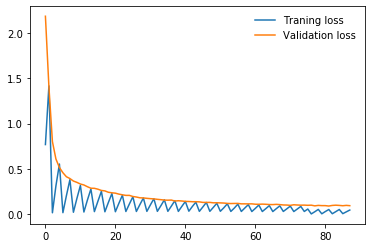

In [12]:
plt.plot(train_losses,label='Traning loss')
plt.plot(test_losses,label='Validation loss')
plt.legend(frameon=False)